# Numerical simulation of FAST applied to a the fine flakes image at various noise levels

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import colorcet as cc
import fast.s26_analysis.utils as utils
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile as tif
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.img_loader import renormalize
from tqdm.notebook import tqdm

In [5]:
frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype("bool"))

In [6]:
diff_data = joblib.load("diffs_roi_for_noisy_fast_sims.joblib")

In [7]:
norm_counts = joblib.load("norm_counts.joblib")

In [8]:
diff_data = diff_data / (norm_counts / norm_counts.mean())[..., None, None]
diff_data_roi = diff_data[..., 85 - 15 : 85 + 15, 85 - 15 : 85 + 15]

In [9]:
diff_data.max(), diff_data.min()

(238.45938246778908, 0.0)

In [10]:
diff_data_roi.shape

(40, 200, 30, 30)

### plotting the data with no additional nosie

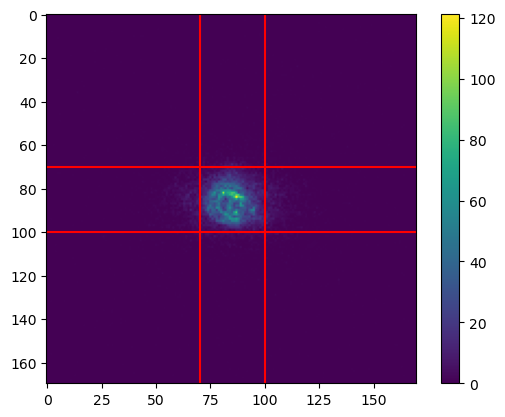

In [11]:
plt.figure()
plt.imshow(diff_data[32, 50])
plt.axvline(85 - 15, color="red")
plt.axvline(85 + 15, color="red")

plt.axhline(85 - 15, color="red")
plt.axhline(85 + 15, color="red")
plt.colorbar()
plt.show()

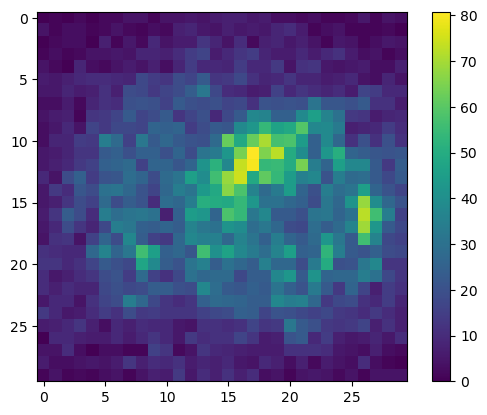

In [12]:
plt.figure()
plt.imshow(diff_data_roi[0, 0])
plt.colorbar()
plt.show()

In [13]:
img_true = renormalize(diff_data_roi.sum(axis=(2, 3)) / norm_counts)

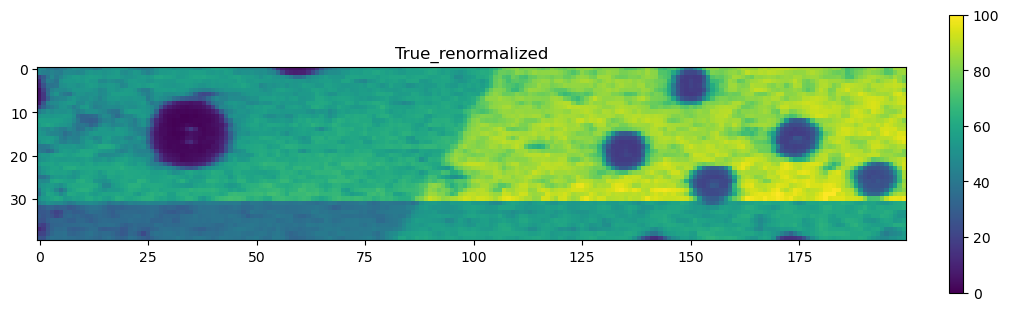

In [14]:
plt.figure(figsize=[10, 3], constrained_layout=True)
plt.imshow(img_true)
plt.title(f"True_renormalized")
plt.colorbar()
plt.show()

In [15]:
for pow_n in range(6):
    fac = 4**pow_n
    dat_new = diff_data_roi / fac
    dat_new_noisy = np.random.poisson(dat_new)
    dat_nonzero = dat_new_noisy[dat_new_noisy > 0]
    print(np.mean(dat_new_noisy**0.5), np.mean(dat_new) / np.mean(dat_new**0.5))

4.2223967808585385 5.204037962928435
2.03001256570127 2.6020189814642176
0.8697042021395052 1.3010094907321088
0.29604321306589637 0.6505047453660544
0.08305017585422772 0.3252523726830272
0.021555504617690527 0.1626261863415136


In [16]:
background_counts = 0.0093

Max count is 23.845938246778907
Max noisy count is 34


/tmp/ipykernel_1454456/57230143.py:27: RuntimeWarning: invalid value encountered in divide
  snrs2[fac] = np.mean(dat_new_noisy_roi / np.sqrt((dat_new_roi - dat_new_noisy_roi) ** 2))


SNR is 1.9877790792364953 nan


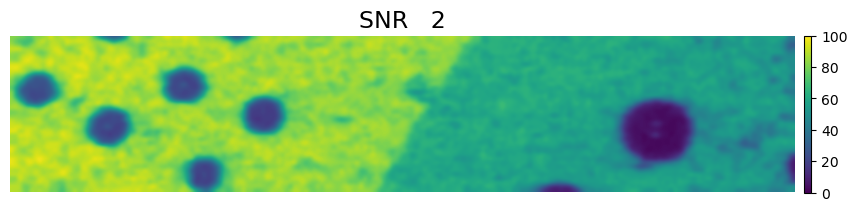

SNR is 1.948804667109563 1.2293914623588076


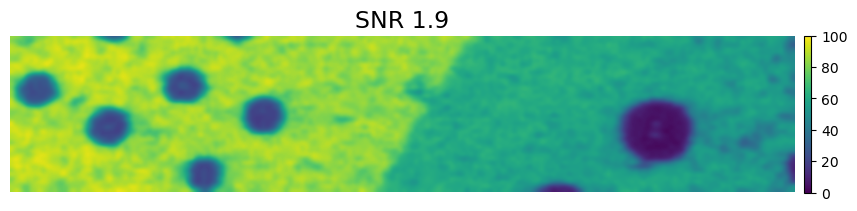

Max count is 2.384593824677891
Max noisy count is 8
SNR is 0.6167405574878583 nan


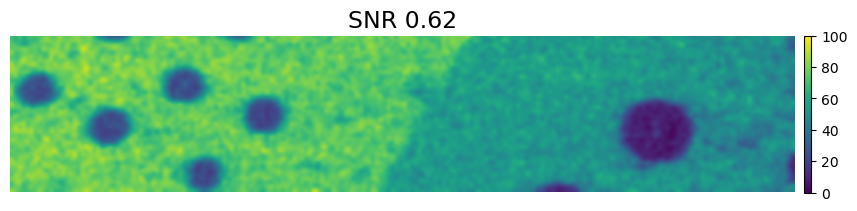

SNR is 0.521993502922613 0.28010740307978704


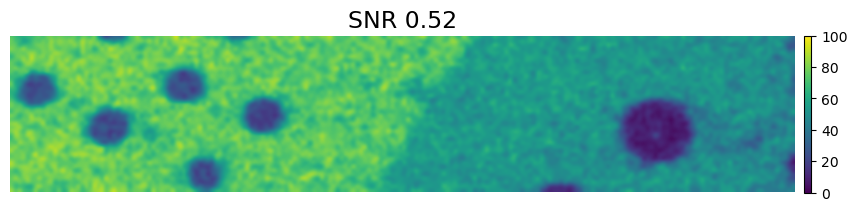

Max count is 0.23845938246778908
Max noisy count is 4
SNR is 0.16684205179739567 nan


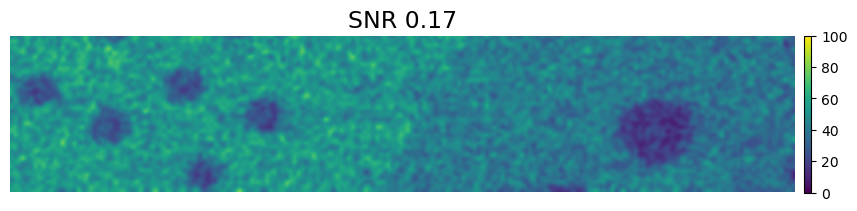

SNR is 0.08438054248543372 0.11128538999705619


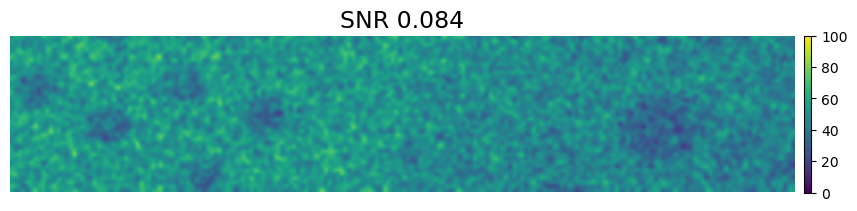

In [17]:
# Noise levels [4, 16, 64, 256, 1024]
snrs = {}
snrs2 = {}
diff_roi_sums_noise = {}
diff_roi_sums_norm_noise = {}
full_diffs_noise = {}

for pow_n in range(1, 4):
    fac = 10**pow_n
    dat_new = diff_data / fac
    dat_new_roi = dat_new[..., 85 - 15 : 85 + 15, 85 - 15 : 85 + 15]
    print("Max count is", dat_new.max())

    dat_new_noisy = np.random.poisson(dat_new + background_counts)
    dat_new_noisy_2 = np.random.poisson(dat_new + background_counts * 10)

    fac2 = f"{fac}_2"
    full_diffs_noise[fac] = dat_new_noisy
    full_diffs_noise[fac2] = dat_new_noisy_2

    print("Max noisy count is", dat_new_noisy.max())

    dat_new_noisy_roi = dat_new_noisy[..., 85 - 15 : 85 + 15, 85 - 15 : 85 + 15]
    dat_new_noisy_roi_2 = dat_new_noisy_2[..., 85 - 15 : 85 + 15, 85 - 15 : 85 + 15]

    snrs[fac] = (np.sum(dat_new_roi**2)) ** 0.5 / (np.sum((dat_new_roi - dat_new_noisy_roi) ** 2)) ** 0.5
    snrs2[fac] = np.mean(dat_new_noisy_roi / np.sqrt((dat_new_roi - dat_new_noisy_roi) ** 2))

    snrs[fac2] = (np.sum(dat_new_roi**2)) ** 0.5 / (np.sum((dat_new_roi - dat_new_noisy_roi_2) ** 2)) ** 0.5
    snrs2[fac2] = np.mean(dat_new_noisy_roi_2**0.5)

    print("SNR is", snrs[fac], snrs2[fac])

    diff_roi_sums_noise[fac] = renormalize(dat_new_noisy_roi.sum(axis=(2, 3)), min_value=0, max_value=100)
    # diff_sums_norm_noise[fac] = diff_sums_noise[fac] / (norm_counts / fac + background_counts * 50 * 50)

    diff_roi_sums_noise[fac2] = renormalize(dat_new_noisy_roi_2.sum(axis=(2, 3)), min_value=0, max_value=100)
    # diff_sums_norm_noise[fac2] = diff_sums_noise[fac2] / (norm_counts / fac + background_counts * 10 * 50 * 50)

    plt.figure(figsize=[10, 2], constrained_layout=True)
    plt.imshow(diff_roi_sums_noise[fac][::-1, ::-1], interpolation="bicubic", rasterized=True)
    plt.title(f"SNR {snrs[fac]:3.2g}", fontsize=17)
    plt.colorbar(pad=0.01)
    plt.axis("off")
    # plt.savefig(f"noise_snr_{snrs[fac]:3.2g}_full_image.svg", bbox_inches="tight", dpi=400, transparent=True)
    # plt.savefig(f"noise_snr_{snrs[fac]:3.2g}_full_image.pdf", bbox_inches="tight", dpi=400, transparent=True)
    plt.show()

    print("SNR is", snrs[fac2], snrs2[fac2])
    plt.figure(figsize=[10, 2], constrained_layout=True)
    plt.imshow(diff_roi_sums_noise[fac2][::-1, ::-1], interpolation="bicubic", rasterized=True)
    plt.title(f"SNR {snrs[fac2]:3.2g}", fontsize=17)
    plt.colorbar(pad=0.01)
    plt.axis("off")
    # plt.savefig(f"noise_snr_{snrs[fac2]:3.2g}_full_image.svg", bbox_inches="tight", dpi=400, transparent=True)
    # plt.savefig(f"noise_snr_{snrs[fac2]:3.2g}_full_image.pdf", bbox_inches="tight", dpi=400, transparent=True)
    plt.show()

In [18]:
save_dir = Path.cwd()
# save_dir.mkdir(exist_ok=True)
load_fname = save_dir / "data_all.joblib"

In [19]:
data_all = joblib.load(load_fname)

In [20]:
ratios_to_plot = [0.05, 0.15, 0.2]
idxs_to_plot = [np.argmin(np.abs(np.array(data_all[10]["scan_ratios"]) - r)) for r in ratios_to_plot]

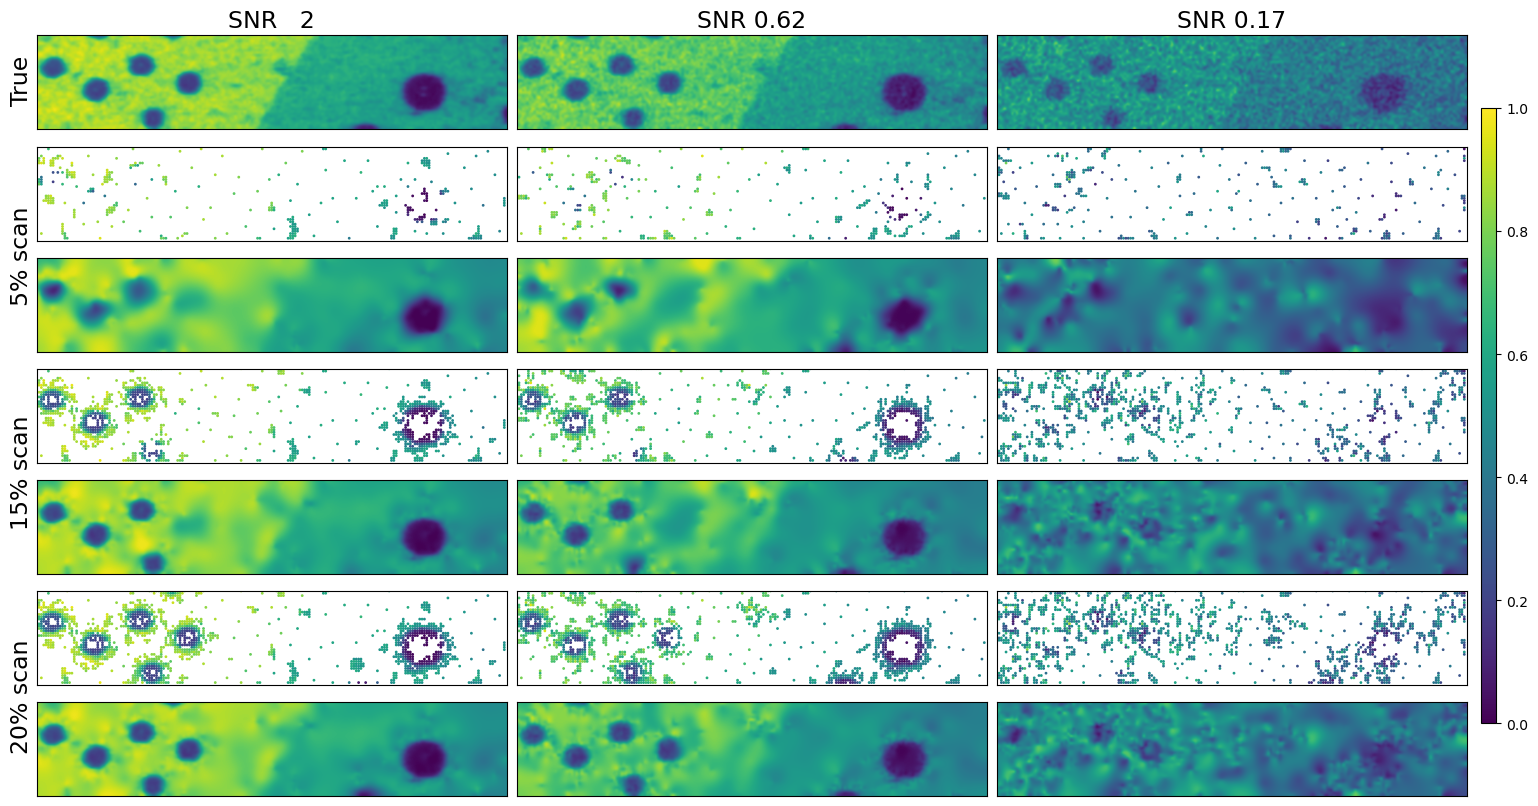

In [21]:
char = ord("A")
fig, axs = plt.subplots(7, 3, figsize=[15, 8], constrained_layout=True)

cmap = mpl.colormaps.get_cmap("viridis").copy()
norm = plt.Normalize(0, 1)

for _ix, (indx, sr) in enumerate(zip(idxs_to_plot, ratios_to_plot)):
    iy = 0
    for label in data_all:
        if label in ["10_2", "100_2", "1000_2"]:
            continue

        mask = data_all[label]["masks"][indx][::-1, ::-1]
        recons = data_all[label]["recons_bh"][indx][::-1, ::-1]

        ypoints, xpoints = np.where(mask)

        img_true = diff_roi_sums_noise[label] / 100

        if _ix == 0:
            axs[0, iy].imshow(img_true[::-1, ::-1], interpolation="bicubic", rasterized=False, norm=norm, cmap=cmap)
            axs[0, iy].set_xticks([])
            axs[0, iy].set_yticks([])

        rmax = img_true[ypoints, xpoints].max()
        rmin = img_true[ypoints, xpoints].min()

        recons_renorm = renormalize(recons, min_value=rmin, max_value=rmax)
        ints = recons_renorm[ypoints, xpoints]

        r1 = _ix * 2 + 1
        axs[r1, iy].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=1.0, rasterized=False, zorder=0)

        # axs[0, iy].scatter(mpos.T[:,1], mpos.T[:,0])
        # axs[0, iy].imshow(mask)
        if _ix == 0:
            axs[0, iy].set_title(f"SNR {snrs[label]:3.2g}", size=17)

        axs[r1, iy].set_xlim([0, 200])
        axs[r1, iy].set_ylim([0, 40])
        axs[r1, iy].set_xticks([])
        axs[r1, iy].set_yticks([])
        axs[r1, iy].set_aspect("equal")

        axs[r1, iy].invert_yaxis()

        r2 = _ix * 2 + 2
        cim = axs[r2, iy].imshow(recons_renorm, interpolation="bicubic", rasterized=False, norm=norm, cmap=cmap)
        axs[r2, iy].set_xticks([])
        axs[r2, iy].set_yticks([])
        # axs[_ix * 2 + 1, iy].text(0.01, 0.78, chr(char + (_ix * 2 + 1) * 3  + iy), transform=axs[_ix * 2 + 1, iy].transAxes, color='red',
        #                          fontsize=16, fontweight='bold', alpha=0.9)

        # if iy == 0:
        #    if _ix == 0:
        #        axs[0, iy].set_ylabel(chr(char), fontsize=14, color="purple")

        #        char += 1
        #    axs[r1, iy].set_ylabel(chr(char), fontsize=14, color="purple")
        #    axs[r2, iy].set_ylabel(chr(char + 1), fontsize=14, color="purple")
        #    char += 2

        iy += 1

fig.text(-0.015, 0.07, "20% scan", rotation="vertical", fontsize=17)
fig.text(-0.015, 0.35, "15% scan", rotation="vertical", fontsize=17)
fig.text(-0.015, 0.63, "5% scan", rotation="vertical", fontsize=17)
fig.text(-0.015, 0.88, "True", rotation="vertical", fontsize=17)

fig.colorbar(cim, ax=axs, shrink=0.8, pad=0.01, aspect=40)

# plt.savefig("noise_recons.svg", bbox_inches="tight", dpi=400, transparent=True)

plt.savefig("noise_recons.pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

In [22]:
0.35 + 0.28

0.63

### Plotting sample diffraction patterns

In [23]:
diffs_to_plot = np.array([956, 4954, 998, 3414])

In [24]:
print(full_diffs_noise.keys())

dict_keys([10, '10_2', 100, '100_2', 1000, '1000_2'])


In [25]:
full_diffs_noise[1] = diff_data
snrs[1] = 100
sort_args = np.argsort(list(snrs.values()))[::-1]

In [26]:
full_diffs_noise.keys()

dict_keys([10, '10_2', 100, '100_2', 1000, '1000_2', 1])

In [27]:
list(snrs.values()), sort_args

([1.9877790792364953,
  1.948804667109563,
  0.6167405574878583,
  0.521993502922613,
  0.16684205179739567,
  0.08438054248543372,
  100],
 array([6, 0, 1, 2, 3, 4, 5]))

In [28]:
full_diffs_noise[1].max()

238.45938246778908

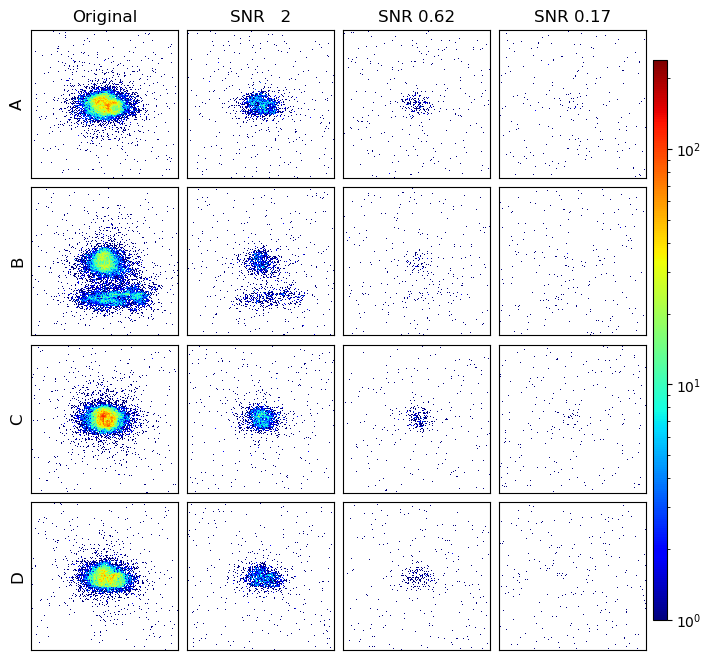

In [29]:
fig, axs = plt.subplots(4, 4, figsize=[7, 6.5], constrained_layout=True)
cmap = plt.cm.jet.copy()
# cmap = cc.cm.linear_worb_100_25_c53_r.copy()
# cmap.set_bad('white')

char = ord("A")
img_count = 0
for iy, nd in enumerate(diffs_to_plot):
    for ix, sortix in enumerate(sort_args):
        scaling = list(full_diffs_noise.keys())[sortix]

        if scaling in ["10_2", "100_2", "1000_2"]:
            continue

        plt.subplot(4, 4, img_count + 1)

        plot_data = full_diffs_noise[scaling][::-1, ::-1][39 - nd // 200, 199 - nd % 200]
        im = plt.pcolormesh(
            plot_data, cmap=cmap, norm=mpl.colors.LogNorm(vmax=full_diffs_noise[1].max()), rasterized=True
        )
        # if ix==0 and iy==0:
        #    plt.colorbar()
        ax = plt.gca()
        ax.set_aspect("equal")
        ax.invert_yaxis()
        if img_count // 4 == 0:
            if scaling != 1:
                ax.set_title(f"SNR {snrs[scaling]:3.2g}", size=12)
            else:
                ax.set_title("Original", size=12)
        if ix == 0:
            ax.set_ylabel(f"{chr(char + iy)}", size=12)
        # axs[ix, iy].axis('off')
        # fig.suptitle(f"Scaling {scaling}, SNR {snrs[scaling]:3.2f}", size=14)
        # plt.tight_layout()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        img_count += 1
        # if iy==2:
        # ax.set_title(f"Scaling {scaling}, SNR {snrs[scaling]:3.2f}", size=12)
fig.colorbar(im, ax=axs.ravel().tolist(), fraction=0.6, shrink=0.9, pad=0.01, aspect=40)  # , location="bottom")
# plt.savefig("example_diffraction_patterns.svg", bbox_inches="tight", dpi=400, transparent=True)
plt.savefig("example_diffraction_patterns.pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

In [39]:
full_diffs_noise[10].shape

(40, 200, 30, 30)